In [1]:
import os
import matplotlib.pyplot as plt  # to visualize data and draw plots
import numpy as np  # to use numpy arrays
import tensorflow as tf  # to specify and run computation graphs

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence

from keras.datasets import imdb 
from keras import backend as K

import seaborn as sns
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [3]:
n_unique_words = 20000
(x_train, y_train),(x_test, y_test) = imdb.load_data(num_words=n_unique_words)

In [4]:
maxlen = 200
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_train.shape

(25000, 200)

In [5]:
class attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences

        super(attention,self).__init__()

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),initializer="normal")
        self.b= self.add_weight(name="att_bias", shape=(input_shape[1],1),initializer="normal")
        self.b= self.add_weight(name="att_bias", shape=(input_shape[1],1))
        # self.b= self.add_weight(name="att_bias", shape=(input_shape[1],1), 

        super(attention,self).build(input_shape)


    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        if self.return_sequences:

            return output
        return K.sum(output, axis=1)

In [6]:
# # Model 1
# model = Sequential()
# model.add(Embedding(n_unique_words, 128, input_length=maxlen))
# model.add(Bidirectional(LSTM(128, return_sequences=True)))
# model.add(Bidirectional(LSTM(64, return_sequences=True)))
# model.add(attention(return_sequences=False)) # receive 3D and output 3D
# model.add(Dropout(0.5))
# model.add(Dense(16, activation='sigmoid'))
# model.add(Dense(1, activation='sigmoid'))


# Model 2

# model = Sequential()
# model.add(Embedding(n_unique_words, 64, input_length=maxlen))
# model.add(Bidirectional(LSTM(64, return_sequences=True)))
# model.add(Bidirectional(LSTM(32, return_sequences=True)))
# model.add(attention(return_sequences=False))
# model.add(Dropout(0.5))
# model.add(Dense(16, activation='sigmoid'))
# model.add(Dense(1, activation='sigmoid'))

# Model 3
model = Sequential()
model.add(Embedding(n_unique_words, 256, input_length=maxlen))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(attention(return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))


In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 256)          5120000   
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 512)          1050624   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          656384    
_________________________________________________________________
attention (attention)        (None, 256)               456       
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [8]:
# Define early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# Define the nuuber of folds for K-fold cross-validation
num_folds = 3
# Define the K-fold cross-validator
kfold = KFold(n_splits=num_folds, shuffle=True)
# Define a list to store the model's performance on each fold
fold_scores = []

In [9]:

# history=model.fit(x_train, y_train,batch_size=32,epochs=12, callbacks=[early_stop])
# print(history.history['loss'])
# print(history.history['accuracy']) 

In [10]:
# Define lists to store fold scores and histories
fold_scores = []
fold_histories = []

# Define the number of epochs to train for
epochs = 10

# Loop over each fold
for fold, (train_indices, val_indices) in enumerate(kfold.split(x_train)):
    print('Fold', fold+1)

    # Split the data into training and validation sets for this fold
    fold_x_train, fold_y_train = x_train[train_indices], y_train[train_indices]
    fold_x_val, fold_y_val = x_train[val_indices], y_train[val_indices]

    # Train the model on this fold's training data
    history = model.fit(fold_x_train, fold_y_train, batch_size=32, epochs=epochs, validation_data=(fold_x_val, fold_y_val), callbacks=[early_stop])

    # Evaluate the model on this fold's validation data
    fold_score = model.evaluate(fold_x_val, fold_y_val, verbose=0)
    print('Validation loss:', fold_score[0])
    print('Validation accuracy:', fold_score[1])

    # Add this fold's score and history to the lists of fold scores and histories
    fold_scores.append(fold_score[1])
    fold_histories.append(history)

Fold 1
Epoch 1/10
521/521 [==============================] - 28s 47ms/step - loss: 0.4941 - accuracy: 0.7616 - val_loss: 0.4700 - val_accuracy: 0.7556
Epoch 2/10
521/521 [==============================] - 24s 45ms/step - loss: 0.2686 - accuracy: 0.8943 - val_loss: 0.3067 - val_accuracy: 0.8772
Epoch 3/10
521/521 [==============================] - 24s 45ms/step - loss: 0.1441 - accuracy: 0.9500 - val_loss: 0.3531 - val_accuracy: 0.8715
Epoch 4/10
521/521 [==============================] - 24s 45ms/step - loss: 0.0748 - accuracy: 0.9763 - val_loss: 0.4227 - val_accuracy: 0.8668
Epoch 5/10
521/521 [==============================] - 24s 45ms/step - loss: 0.0566 - accuracy: 0.9818 - val_loss: 0.4625 - val_accuracy: 0.8629
Epoch 6/10
521/521 [==============================] - 24s 45ms/step - loss: 0.0459 - accuracy: 0.9861 - val_loss: 0.4250 - val_accuracy: 0.8665
Epoch 7/10
521/521 [==============================] - 24s 45ms/step - loss: 0.0255 - accuracy: 0.9931 - val_loss: 0.6216 - val_ac

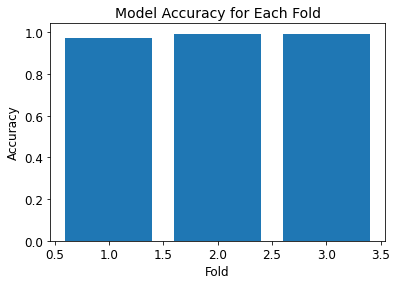

In [32]:
import matplotlib.pyplot as plt

# Plot the model's accuracy for each fold
plt.bar(range(1, len(fold_scores)+1), fold_scores)
plt.xlabel('Fold')
plt.ylabel('Training Accuracy')
plt.title('Model Accuracy for Each Fold')
plt.savefig('Fold Accuracy', dpi=300, bbox_inches='tight')
plt.show()

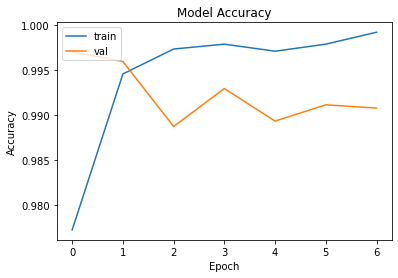

In [12]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Model Acc', dpi=300, bbox_inches='tight')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Model Loss', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
# OLD FOLD TRAINING MEthod


# # Loop over each fold
# for fold, (train_indices, val_indices) in enumerate(kfold.split(x_train)):
#     print('Fold', fold+1)

#     # Split the data into training and validation sets for this fold
#     fold_x_train, fold_y_train = x_train[train_indices], y_train[train_indices]
#     fold_x_val, fold_y_val = x_train[val_indices], y_train[val_indices]

#     # Train the model on this fold's training data
#     model.fit(fold_x_train, fold_y_train, batch_size=32, epochs=10, validation_data=(fold_x_val, fold_y_val), callbacks=[early_stop])

#     # Evaluate the model on this fold's validation data
#     fold_score = model.evaluate(fold_x_val, fold_y_val, verbose=0)
#     print('Validation loss:', fold_score[0])
#     print('Validation accuracy:', fold_score[1])

#     # Add this fold's score to the list of fold scores
#     fold_scores.append(fold_score[1])

In [51]:
# test data
loss, accuracy = model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

782/782 [==============================] - 12s 16ms/step - loss: 0.7693 - accuracy: 0.8518
Test Loss: 0.769325315952301
Test Accuracy: 0.8517600297927856


In [52]:
Y_pred = model.predict(x_test)
Y_pred = Y_pred.ravel() 
y_pred_binary = np.where(Y_pred >= 0.5, 1, 0)

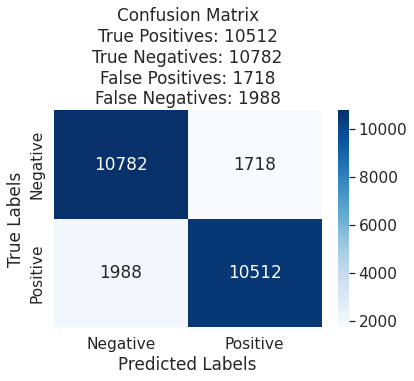

In [53]:
conf_matrix = confusion_matrix(y_test, y_pred_binary)
tn, fp, fn, tp = conf_matrix.ravel()

sns.set(font_scale=1.4)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix\nTrue Positives: {tp}\nTrue Negatives: {tn}\nFalse Positives: {fp}\nFalse Negatives: {fn}')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()